## Agenda

- To Predict whether or not a strike between an aircraft and wildlife cause damage to the aircraft
- To understand what factors influence the level of damage given a case of collision between wildlife and an aircraft
- To throw light on the cost of repair borne by the US Civil Aviation Industry when such collisions happen

In [1]:
# Import Libraries
import pyodbc
import pandas as pd
import numpy as np
from pandas import DataFrame
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

### Creating a Connection with Access Database and Pulling Data into Python

In [2]:
pyodbc.dataSources()

{'Excel Files': 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'MS Access Database': 'Microsoft Access Driver (*.mdb, *.accdb)',
 'dBASE Files': 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)'}

In [3]:
# Define components of our connection string
driver = '{Microsoft Access Driver (*.mdb, *.accdb)}'
filepath = 'data/wildlife.accdb'

# Create connection String to the Database

cnxn = pyodbc.connect(driver = driver, dbq = filepath)

crsr = cnxn.cursor()

In [4]:
# Define the components of our query
table_name = 'STRIKE_REPORTS'

# define a query
query = 'SELECT * FROM {}'.format(table_name)

#execute the query
crsr.execute(query)

In [5]:
# fetch one row
one_row = crsr.fetchone()
one_row

(608274, datetime.datetime(1990, 10, 15, 0, 0), 10, 1990, None, 'Night', 'KMIE', 'DELAWARE COUNTY REGIONAL ARPT', Decimal('40.24235000'), Decimal('-85.39586000'), None, 'IN', 'AGL ', None, 'PVT', 'PRIVATELY OWNED', 'NULL', 'NULL', 'C-172', '226', '07', '07', '10', 'A  ', '1', 'A', '1', '7', 'NULL', 'NULL', 'NULL', 'Approach', 200, 70, None, 'No Cloud', 'None', None, None, None, None, None, False, False, 'N', False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, None, None, None, None, 'UNKBS', 'Unknown bird - small', 'NO DAMAGE', False, False, 'No', '1', '1', 'Small', None, None, None, 'OPER = CHARLES WEATHERLY /Legacy Record=100033/', 'REDACTED', 'REDACTED', 'FAA Form 5200-7', 'Tower', datetime.datetime(1998, 12, 4, 0, 0), False)

In [6]:
# Access one column

display(one_row[0])
display(one_row.TIME_OF_DAY)

608274

'Night'

In [7]:
# call the data into a pandas dataframe
wildlife = pd.read_sql(sql = query, con = cnxn)

In [8]:
wildlife.shape

(256679, 100)

In [9]:
#Looking at Column Names and DataTypes
wildlife.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256679 entries, 0 to 256678
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   INDEX_NR               256679 non-null  int64         
 1   INCIDENT_DATE          256679 non-null  datetime64[ns]
 2   INCIDENT_MONTH         256679 non-null  int64         
 3   INCIDENT_YEAR          256679 non-null  int64         
 4   TIME                   135604 non-null  object        
 5   TIME_OF_DAY            149838 non-null  object        
 6   AIRPORT_ID             256679 non-null  object        
 7   AIRPORT                256679 non-null  object        
 8   LATITUDE               225331 non-null  float64       
 9   LONGITUDE              225331 non-null  float64       
 10  RUNWAY                 194163 non-null  object        
 11  STATE                  225331 non-null  object        
 12  FAAREGION              225331 non-null  obj

In [10]:
#Converting Column Names to Lowercase
wildlife.columns = wildlife.columns.str.lower()

In [12]:
wildlife.head()

,index_nr,incident_date,incident_month,incident_year,time,time_of_day,airport_id,airport,latitude,longitude,...,enroute_state,nr_injuries,nr_fatalities,comments,reported_name,reported_title,source,person,lupdate,transfer
0,608274,1990-10-15,10,1990,None,Night,KMIE,DELAWARE COUNTY REGIONAL ARPT,40.24235,-85.39586,...,None,NaN,NaN,OPER = CHARLES WEATHERLY /Legacy Record=100033/,REDACTED,REDACTED,FAA Form 5200-7,Tower,1998-12-04,False
1,608275,1993-08-01,8,1993,None,Day,KMSY,LOUIE ARMSTRONG NEW ORLEANS INTL ARPT,29.99339,-90.25803,...,None,NaN,NaN,/Legacy Record=100034/,REDACTED,REDACTED,AC Incident Rept,Tower,2005-05-24,False
2,608276,1996-08-18,8,1996,None,None,KORD,CHICAGO O'HARE INTL ARPT,41.97960,-87.90446,...,None,NaN,NaN,/Legacy Record=100035/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,False
3,608277,1993-09-19,9,1993,None,Day,KMHT,MANCHESTER AIRPORT,42.93452,-71.43706,...,None,NaN,NaN,SOURCE = 5200-7 & NON-COM INCIDENT REPT.OPERAT...,REDACTED,REDACTED,Multiple,Tower,1998-05-11,False
4,608278,1991-03-23,3,1991,None,Night,KELP,EL PASO INTL ARPT,31.80667,-106.37781,...,None,NaN,NaN,/Legacy Record=100037/,REDACTED,REDACTED,FAA Form 5200-7,Pilot,1998-05-28,False


In [11]:
#Copying Dataset for EDA
acraftvswild = wildlife.copy()

### Removing Unnecessary columns from the data

In [12]:
acraftvswild.drop(['transfer', 'lupdate', 'person', 'source', 'reported_name', 'reported_title', 'index_nr'], axis=1, inplace=True)

In [13]:
acraftvswild.describe()

,incident_month,incident_year,latitude,longitude,height,speed,distance,aos,cost_repairs,cost_other,cost_repairs_infl_adj,cost_other_infl_adj,bird_band_number,nr_injuries,nr_fatalities
count,256679.000000,256679.000000,225331.000000,225331.000000,135938.000000,87446.000000,164557.000000,12767.000000,4.851000e+03,4.392000e+03,4.851000e+03,4.392000e+03,5.400000e+01,258.000000,17.000000
mean,7.224416,2010.485556,36.892175,-91.645543,861.317571,142.388434,0.786167,91.891345,1.306724e+05,1.859627e+04,1.648377e+05,2.378029e+04,1.626670e+08,1.298450,2.294118
std,2.775898,7.973133,6.859315,25.019876,1839.807010,46.360404,3.528900,409.965075,7.973260e+05,1.286105e+05,9.727042e+05,1.799322e+05,6.236813e+07,0.774143,1.896204
min,1.000000,1990.000000,-37.673333,-177.381000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000
25%,5.000000,2005.000000,33.220630,-99.965610,0.000000,120.000000,0.000000,1.000000,2.500000e+03,2.000000e+02,3.165000e+03,2.307500e+02,1.357785e+08,1.000000,1.000000
50%,8.000000,2012.000000,38.805810,-87.904460,50.000000,140.000000,0.000000,3.000000,1.141700e+04,6.000000e+02,1.477000e+04,6.900000e+02,1.893115e+08,1.000000,2.000000
75%,9.000000,2017.000000,40.850970,-80.417940,800.000000,160.000000,0.000000,24.000000,5.000000e+04,5.000000e+03,5.940000e+04,6.547500e+03,1.947486e+08,1.000000,3.000000
max,12.000000,2021.000000,71.285450,178.559228,31300.000000,1250.000000,99.000000,10080.000000,3.600000e+07,5.000000e+06,4.341600e+07,6.610000e+06,2.791613e+08,7.000000,8.000000


#### Check cost of repair with respect to cases where damage was indicated 

In [14]:
acraftvswild.groupby(['indicated_damage'])['cost_repairs'].sum()

indicated_damage
False        28885.0
True     633863058.0
Name: cost_repairs, dtype: float64

Text(0.5, 1.0, 'Repair Cost where Plane Damage was Indicated')

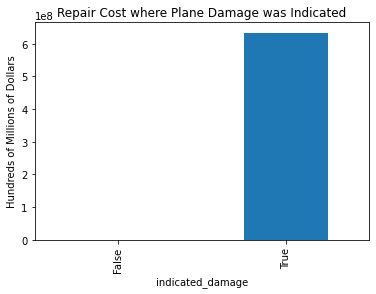

In [23]:
acraftvswild.groupby(['indicated_damage'])['cost_repairs'].sum().plot(kind = 'bar')
plt.ylabel("Hundreds of Millions of Dollars")
plt.title("Repair Cost where Plane Damage was Indicated")

#### The repair cost for strikes where damage was indicated was almost $634M

In [25]:
acraftvswild.groupby(['indicated_damage'])['cost_repairs'].count()

indicated_damage
False      33
True     4818
Name: cost_repairs, dtype: int64

#### There were total 4818 such cases where damage was indicated and repair_cost was incurred

### Replacing damage_level acronyms with values

In [26]:
acraftvswild.groupby(['damage_level'])['cost_repairs'].count()

damage_level
D       35
M     2071
M?    1100
N       30
S     1608
Name: cost_repairs, dtype: int64

In [27]:
damage_repl_dict = {'D' : 'Destroyed - Beyond Repair', 'M' : 'Minor Damage', 'M?' : 'Uncertain Damage', 
                                    'N' : 'No Damage', 'S' : 'Major Damage'}

In [28]:
acraftvswild['damage_level_code'] = acraftvswild.damage_level.replace(damage_repl_dict)

In [29]:
acraftvswild.groupby(['damage_level_code'])['cost_repairs'].sum().sort_values(ascending = True)

damage_level_code
No Damage                       106235.0
Minor Damage                  37070677.0
Destroyed - Beyond Repair     65291500.0
Uncertain Damage              71272288.0
Major Damage                 460148293.0
Name: cost_repairs, dtype: float64

Text(0.5, 1.0, 'Repair Cost by Level of Damage')

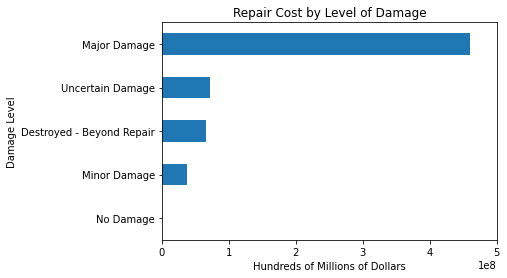

In [30]:
acraftvswild.groupby(['damage_level_code'])['cost_repairs'].sum().sort_values(ascending = True).plot(kind = 'barh')
plt.xlabel("Hundreds of Millions of Dollars")
plt.xlim([0,500000000])
plt.ylabel("Damage Level")
plt.title("Repair Cost by Level of Damage")

#### Almost 72.5% of the cost of repair was incurred where Major Damage was caused by strikes

In [32]:
acraftvswild['effect'].unique()

array([None, 'None', 'Precautionary Landing', 'Aborted Take-off', 'Other',
       'Engine Shutdown', 'Engine Shutdown, Precautionary Landing',
       'Aborted Take-off, Engine Shutdown',
       'Aborted Take-off, Engine Shutdown, Other', 'None, Other',
       'Aborted Take-off, Precautionary Landing'], dtype=object)

#### Looking at the top 10 operators by number of strikes where damage was indicated

In [33]:
acraftvswild.loc[acraftvswild.indicated_damage == True].groupby(['operator'])['indicated_damage'].count().sort_values(ascending = False).head(10)

operator
BUSINESS              5108
UNITED AIRLINES       1344
PRIVATELY OWNED       1314
SOUTHWEST AIRLINES    1149
AMERICAN AIRLINES     1001
DELTA AIR LINES        909
1US AIRWAYS            576
FEDEX EXPRESS          428
UPS AIRLINES           390
SKYWEST AIRLINES       295
Name: indicated_damage, dtype: int64

In [34]:
operator_cost = acraftvswild.groupby(['operator'])['cost_repairs'].sum()

In [35]:
acraftvswild.groupby(['operator'])['cost_repairs'].sum().sort_values(ascending = False).where(operator_cost >= 10000000).dropna()

operator
BUSINESS                          137528520.0
FEDEX EXPRESS                      75503956.0
UNITED AIRLINES                    68814394.0
US AIRWAYS                         38778304.0
DELTA AIR LINES                    36146817.0
JETBLUE AIRWAYS                    35760450.0
AMERICAN AIRLINES                  25357412.0
BOEING COMMERCIAL AIRPLANE GRP     15398260.0
SOUTHWEST AIRLINES                 14667842.0
SKYWEST AIRLINES                   13904092.0
UPS AIRLINES                       11964534.0
Name: cost_repairs, dtype: float64

In [38]:
acraftvswild.time_of_day.value_counts()

Day      91934
Night    45552
Dusk      6838
Dawn      5514
Name: time_of_day, dtype: int64

In [39]:
acraftvswild.phase_of_flight.value_counts()

Approach        67622
Landing Roll    28949
Take-off Run    27653
Climb           24902
En Route         4799
Departure        2106
Descent          2077
Local             861
Arrival           633
Taxi              586
Parked            105
Unknown            11
Name: phase_of_flight, dtype: int64

Text(0, 0.5, 'Phase of Flight')

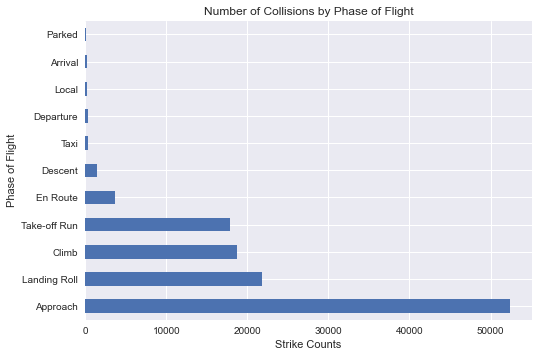

In [125]:
acraftvswild.phase_of_flight.value_counts().plot(kind = 'barh')
plt.title("Number of Collisions by Phase of Flight")
plt.xlabel('Strike Counts')
plt.ylabel('Phase of Flight')

In [40]:
acraftvswild.phase_of_flight.isnull().value_counts()

False    160304
True      96375
Name: phase_of_flight, dtype: int64

#### Out of a Total of 256679 cases of strike, we do not have data about the phase of flight during which the strike took place for 96,375 records.

In [41]:
acraftvswild['size'].value_counts()

Small     157387
Medium     63333
Large      16643
Name: size, dtype: int64

In [42]:
acraftvswild.groupby(['size'])['cost_repairs'].sum()

size
Large     342670915.0
Medium    207667182.0
Small      79367725.0
Name: cost_repairs, dtype: float64

### Comparing the species vs size of birds causing the most strikes

Text(0.5, 0, 'Number of Strikes')

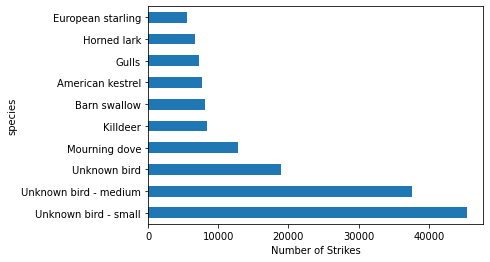

In [43]:
acraftvswild.groupby('species').size().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.xlabel('Number of Strikes')

Text(0.5, 1.0, 'Number of Strikes by Bird Size')

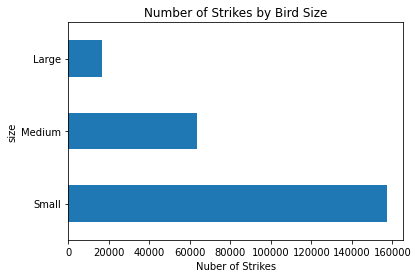

In [45]:
acraftvswild.groupby('size').size().sort_values(ascending = False).plot(kind = 'barh')
plt.xlabel('Nuber of Strikes')
plt.title("Number of Strikes by Bird Size")

#### Even though we do not have the exact species causing the highest number of strikes, we can definitely comment on the size i.e. Small size birds cause a significantly high number of strikes as compared to Large birds

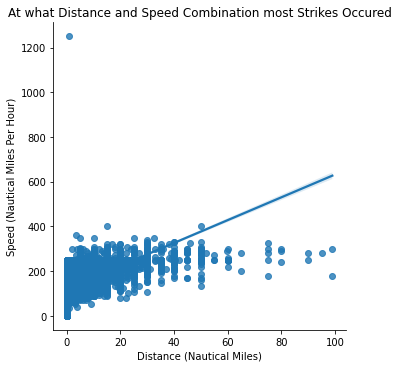

In [51]:
j = sns.lmplot(x="distance", y="speed", data=acraftvswild)
j.set(xlabel = 'Distance (Nautical Miles)', ylabel = 'Speed (Nautical Miles Per Hour)',
      title = "At what Distance and Speed Combination most Strikes Occured")

As we earlier saw that the highest number of strikes happen during the "Approach" phase of flight. Something similar is replecated above as we can see most of the strikes happening within 40 Nautical Miles of the Airport. 

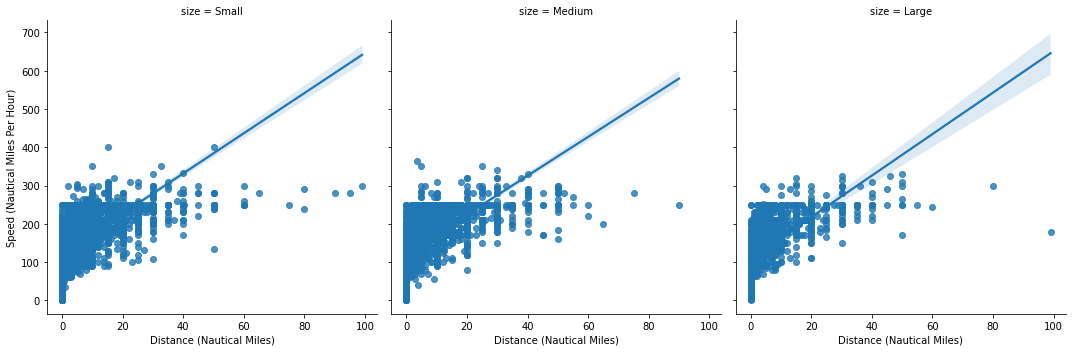

In [63]:
jx = sns.lmplot(x="distance", y="speed", col='size', data=acraftvswild)
jx.set(xlabel = 'Distance (Nautical Miles)', ylabel = 'Speed (Nautical Miles Per Hour)')

### Setting Incident date as index for time series analysis

In [53]:
acraftvswild_dateindex = acraftvswild.set_index('incident_date')
acraftvswild_dateindex.head(2)

,incident_month,incident_year,time,time_of_day,airport_id,airport,latitude,longitude,runway,state,...,remains_sent,warned,num_seen,num_struck,size,enroute_state,nr_injuries,nr_fatalities,comments,damage_level_code
incident_date,,,,,,,,,,,,,,,,,,,,,
1990-10-15,10,1990,None,Night,KMIE,DELAWARE COUNTY REGIONAL ARPT,40.24235,-85.39586,None,IN,...,False,No,1,1,Small,None,NaN,NaN,OPER = CHARLES WEATHERLY /Legacy Record=100033/,No Damage
1993-08-01,8,1993,None,Day,KMSY,LOUIE ARMSTRONG NEW ORLEANS INTL ARPT,29.99339,-90.25803,1,LA,...,False,Unknown,NULL,1,Medium,None,NaN,NaN,/Legacy Record=100034/,No Damage


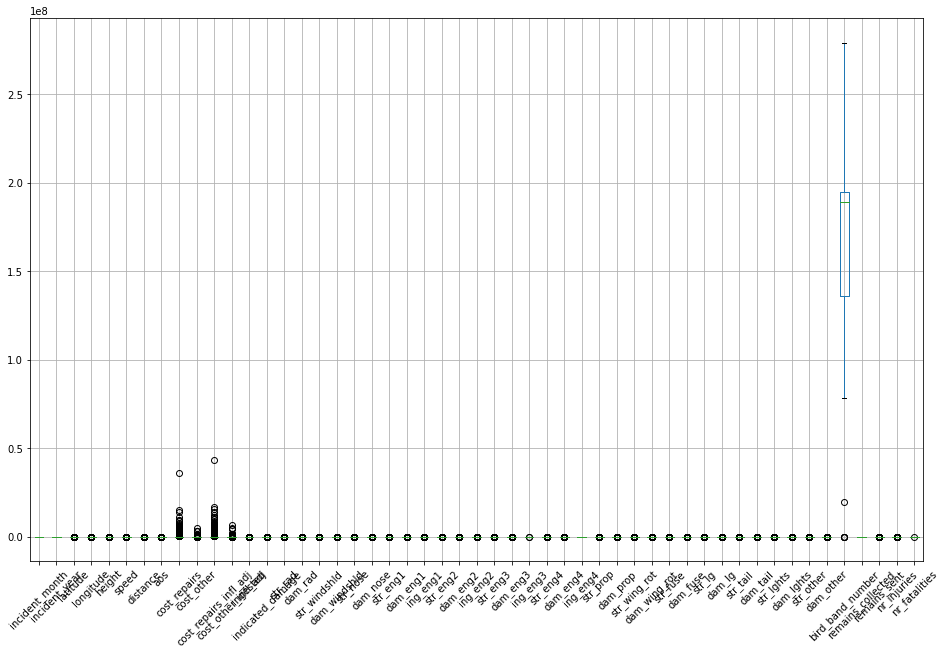

In [54]:
plt.figure(figsize=(16,10))
acraftvswild_dateindex.boxplot()
plt.xticks(rotation=45)
plt.show()

In [55]:
acraftvswild_dateindex.head()

,incident_month,incident_year,time,time_of_day,airport_id,airport,latitude,longitude,runway,state,...,remains_sent,warned,num_seen,num_struck,size,enroute_state,nr_injuries,nr_fatalities,comments,damage_level_code
incident_date,,,,,,,,,,,,,,,,,,,,,
1990-10-15,10,1990,None,Night,KMIE,DELAWARE COUNTY REGIONAL ARPT,40.24235,-85.39586,None,IN,...,False,No,1,1,Small,None,NaN,NaN,OPER = CHARLES WEATHERLY /Legacy Record=100033/,No Damage
1993-08-01,8,1993,None,Day,KMSY,LOUIE ARMSTRONG NEW ORLEANS INTL ARPT,29.99339,-90.25803,1,LA,...,False,Unknown,NULL,1,Medium,None,NaN,NaN,/Legacy Record=100034/,No Damage
1996-08-18,8,1996,None,None,KORD,CHICAGO O'HARE INTL ARPT,41.97960,-87.90446,22R,IL,...,False,Unknown,NULL,1,Small,None,NaN,NaN,/Legacy Record=100035/,No Damage
1993-09-19,9,1993,None,Day,KMHT,MANCHESTER AIRPORT,42.93452,-71.43706,35,NH,...,False,No,2-10,1,Large,None,NaN,NaN,SOURCE = 5200-7 & NON-COM INCIDENT REPT.OPERAT...,Major Damage
1991-03-23,3,1991,None,Night,KELP,EL PASO INTL ARPT,31.80667,-106.37781,26L,TX,...,False,No,NULL,1,Small,None,NaN,NaN,/Legacy Record=100037/,No Damage


In [56]:
year = acraftvswild_dateindex.resample('Y').size()
year.head()

incident_date
1990-12-31    1848
1991-12-31    2389
1992-12-31    2567
1993-12-31    2575
1994-12-31    2634
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Strike Count')

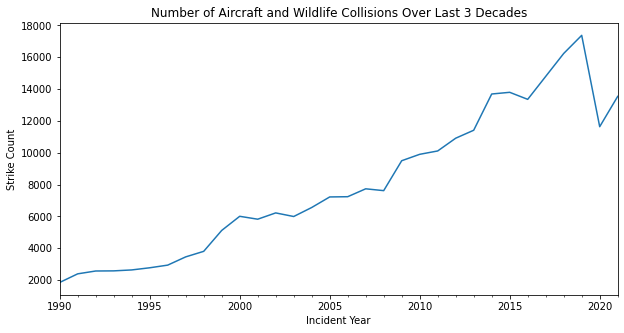

In [58]:
plt.figure(figsize=[10,5])
year.plot()
plt.title("Number of Aircraft and Wildlife Collisions Over Last 3 Decades")
plt.xlabel("Incident Year")
plt.ylabel("Strike Count")

#### After plotting the number of cases over the years we can see that the number of strikes has been almost continuously increasing. We see a sharp dip in strikes in the year 2020. This could probably be cause of lesser number of flights running due to the pandemic.

### Below we dive deeper into the analysis by looking at the number of strikes month wise and comparing results for the years 2010 to 2020

In [59]:
df10 = acraftvswild[acraftvswild['incident_year']>= 2010]
df10 = df10.assign(strike_count = 1)

In [60]:
piv10 = pd.pivot_table(df10, index=['incident_month'],columns=['incident_year'], values = ['strike_count'], aggfunc= sum)

#### Removing year 2021 from comparison as the year is not complete yet.

In [61]:
piv10.drop([('strike_count', 2021)], axis = 1, inplace = True)

Text(0.5, 0, 'Strike Month')

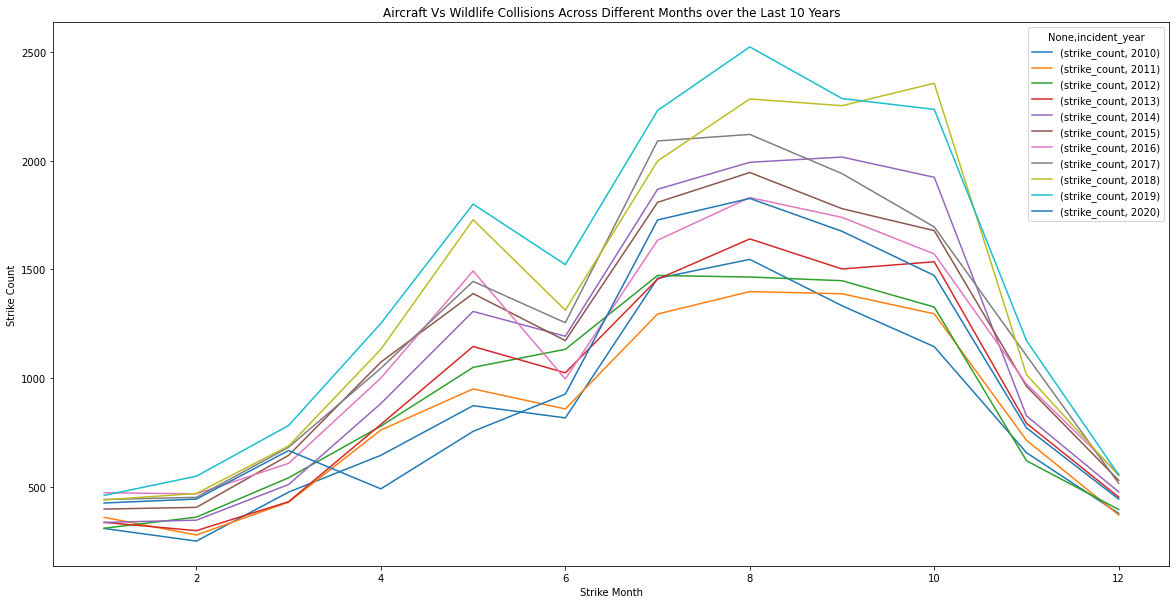

In [62]:
piv10.plot(figsize = (20,10))
plt.title("Aircraft Vs Wildlife Collisions Across Different Months over the Last 10 Years")
plt.ylabel("Strike Count")
plt.xlabel("Strike Month")

#### Here we have found a very noticebale pattern in the number of strikes over the course of any given year. The peak takes place between the months July and October followed by a smaller peak in the month of May.

### Looking at top 10 Airports by number of cases of strikes

In [64]:
acraftvswild['airport'].value_counts().sort_values(ascending=False).head(10)

UNKNOWN                            31271
DENVER INTL AIRPORT                 8376
DALLAS/FORT WORTH INTL ARPT         7142
CHICAGO O'HARE INTL ARPT            5674
JOHN F KENNEDY INTL                 4625
MEMPHIS INTL                        4340
SALT LAKE CITY INTL                 3369
SACRAMENTO INTL                     3359
DETROIT METRO WAYNE COUNTY ARPT     3180
ORLANDO INTL                        3143
Name: airport, dtype: int64

Text(0, 0.5, 'Airport Name')

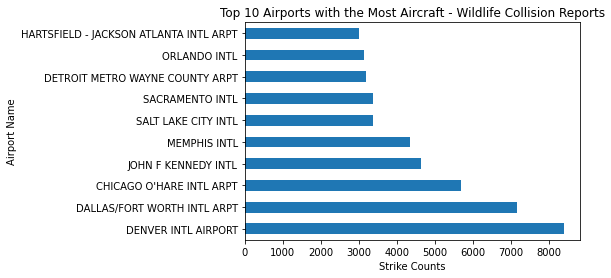

In [65]:
acraftvswild['airport'].value_counts().sort_values(ascending=False)[1:].head(10).plot(kind = "barh")
plt.title("Top 10 Airports with the Most Aircraft - Wildlife Collision Reports")
plt.xlabel("Strike Counts")
plt.ylabel("Airport Name")

### Comparing Numerical Columns to find a pattern

In [74]:
nums = acraftvswild[['height', 'speed', 'distance', 'aos']]

<AxesSubplot:>

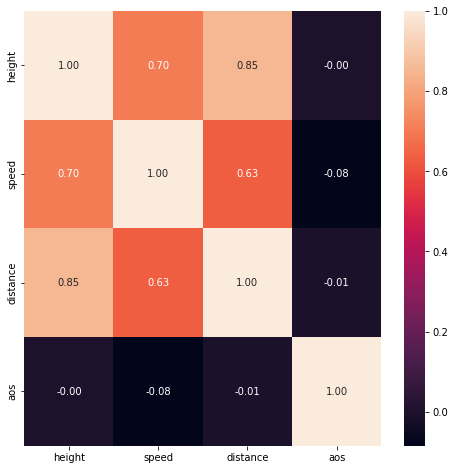

In [75]:
plt.figure(figsize=(8, 8))
sns.heatmap(nums.corr(), annot=True, fmt='.2f')

#### There seems to be a directly propotional relationship between speed, distance and time. We can use all these three columns in our prediction of whether a strike would cause damage to the aircraft or not.

In [76]:
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

### Removing Null Values in Damage Level

In [78]:
acraftvswild.dropna(axis=0, subset=['damage_level'], inplace = True )

In [79]:
acraftvswild['time_of_day'].unique()

array(['Night', 'Day', None, 'Dawn', 'Dusk'], dtype=object)

##### Looking at the pattern of damage level by time of day for the last 5 year excluding 2021

In [80]:
df20 = acraftvswild[acraftvswild['incident_year']>= 2016]
df20 = df20.assign(strike_count = 1)

In [81]:
piv20 = pd.pivot_table(df20, index=['time_of_day'],columns=['incident_year'], values = ['damage_level'], aggfunc= 'count')

In [82]:
piv20

damage_level                              
incident_year         2016  2017  2018  2019  2020  2021
time_of_day                                             
Dawn                   260   271   275   259   194   197
Day                   3917  3799  4196  3373  2451  2786
Dusk                   342   286   342   348   258   303
Night                 2000  2103  2563  2254  1362  1692

In [83]:
piv20.drop([('damage_level', 2021)], axis = 1, inplace = True)

Text(0, 0.5, 'Strike Count')

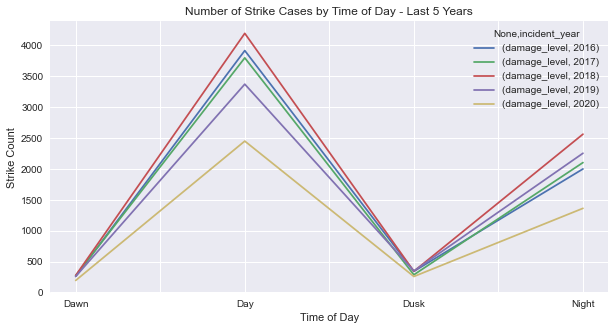

In [84]:
piv20.plot(figsize = (10,5))
plt.title("Number of Strike Cases by Time of Day - Last 5 Years")
plt.xlabel("Time of Day")
plt.ylabel("Strike Count")

##### We see here a peak in the number of strikes between Aircrafts and wildlife during Day time and Night time as comapred to Dusk and Dawn.

### As we will be predicting whether or not a strike will cause damage to an aircraft or not we need to remove some irrelevant columns first

In [85]:
acraftvswild.drop(['enroute_state', 'nr_injuries', 'nr_fatalities', 'bird_band_number', 'effect_other', 
                   'cost_repairs', 'cost_other', 'cost_repairs_infl_adj', 'cost_other_infl_adj',
                   'airport_id', 'latitude', 'longitude', 'runway', 'faaregion', 'location', 'opid',
                   'reg', 'aircraft', 'flt', 'ama', 'amo', 'aos', 'other_specify', 'effect',
                   'species_id', 'species', 'remarks', 'remains_collected', 'remains_sent', 'comments',
                   'incident_date', 'incident_month', 'incident_year', 'time'], axis=1, inplace=True)

### Apart from this we have a few columns with code values which need to be turned into string values using the dictionary available with the dataset, in order for the columns to make sense. We will first create dictionaries for every such column, and replace them with a new column with "_code" as suffix

In [86]:
ac_class_repl_dict = {'A' : 'Airplane', 'B' : 'Helicopter', 'C' : 'Glider', 'D' : 'Balloon', 'F' : 'Dirigible',
                      'I' : 'Gyroplane', 'J' : 'Ultralight', 'Y' : 'Other', 'Z' : 'Unkown'}

In [87]:
acraftvswild['ac_class_code'] = acraftvswild.ac_class.replace(ac_class_repl_dict)

#### Apparently we are not able to replace the values as expected. Below we check for extra spaces in the string values

In [88]:
acraftvswild['ac_class'].unique()

array(['A  ', 'NULL', 'B  ', 'J  ', 'C  ', None, 'Y  '], dtype=object)

As we can see every value has 2 extra spaces at the end. We use strip() to remove extra spaces and continue with the conversion

In [89]:
acraftvswild['ac_class'] = acraftvswild['ac_class'].str.strip()

In [90]:
acraftvswild['ac_class_code'] = acraftvswild.ac_class.replace(ac_class_repl_dict)

We follow the same practice for columns "ac_mass", "type_eng", "eng_1_pos", "eng_2_pos", "eng_3_pos" and "eng_4_pos"

In [91]:
ac_mass_repl_dict = {'1' : '2250 kg or less', '2' : '2251-5700 kg', '3' : '5701-27000 kg', '4' : '27001-272000 kg',
                      '5' : 'above 272000 kg'}

In [92]:
acraftvswild['ac_mass_code'] = acraftvswild.ac_mass.replace(ac_mass_repl_dict)

In [93]:
type_eng_repl_dict = {'A' : 'Reciprocating Engine (Piston)', 'B' : 'Turbojet', 'C' : 'Turboprop', 'D' : 'Turbofan',
                      'E' : 'None (Glider)', 'F' : 'Turboshaft (Helicopter)', 'Y' : 'Other'}

In [94]:
acraftvswild['type_eng_code'] = acraftvswild.type_eng.replace(type_eng_repl_dict)

In [95]:
eng_pos_repl_dict = {'1' : 'Below The Wing', '2' : 'Above The Wing', '3' : 'At Wing Root', '4' : 'Nacelle-Mounted on Wing',
                      '5' : 'On Aft Fuselage', '6' : 'In Empennage', '7' : 'At Nose Intake'}

In [96]:
acraftvswild['eng_1_pos_code'] = acraftvswild.eng_1_pos.replace(eng_pos_repl_dict)

In [97]:
acraftvswild['eng_2_pos_code'] = acraftvswild.eng_2_pos.replace(eng_pos_repl_dict)

In [98]:
acraftvswild['eng_3_pos_code'] = acraftvswild.eng_3_pos.replace(eng_pos_repl_dict)

In [99]:
acraftvswild['eng_4_pos_code'] = acraftvswild.eng_4_pos.replace(eng_pos_repl_dict)

In [100]:
acraftvswild.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169153 entries, 0 to 256678
Data columns (total 67 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_of_day        132840 non-null  object 
 1   airport            169153 non-null  object 
 2   state              139747 non-null  object 
 3   operator           169153 non-null  object 
 4   ema                154263 non-null  object 
 5   emo                151407 non-null  object 
 6   ac_class           169103 non-null  object 
 7   ac_mass            169103 non-null  object 
 8   type_eng           167354 non-null  object 
 9   num_engs           169103 non-null  object 
 10  eng_1_pos          169103 non-null  object 
 11  eng_2_pos          169103 non-null  object 
 12  eng_3_pos          169103 non-null  object 
 13  eng_4_pos          169103 non-null  object 
 14  phase_of_flight    143601 non-null  object 
 15  height             123610 non-null  float64
 16  sp

In [101]:
# Removing some more irrelevant columns 
acraftvswild.drop(['airport', 'state', 'operator', 'ema', 'emo', 'ac_class', 'ac_mass', 'type_eng', 
                   'eng_1_pos', 'eng_2_pos', 'eng_3_pos', 'eng_4_pos', 'sky', 'precipitation',
                    'warned', 'num_seen'], axis=1, inplace=True)

### Since, we will be predicting whether or not a strike causes damage to the aircraft, in order to prevent data leakage to our model we need to eliminate the following columns where the damage details are explicitly given.

In [102]:
acraftvswild.drop(['dam_nose', 'dam_eng1', 'dam_eng2', 'dam_eng3', 'dam_eng4',
                   'dam_prop', 'dam_wing_rot', 'dam_fuse', 'dam_lg', 'dam_tail',
                   'dam_lghts', 'dam_other', 'damage_level', 'dam_rad', 'dam_windshld'], axis=1, inplace=True)

In [103]:
acraftvswild.drop(['damage_level_code'], axis=1, inplace=True)

### Checking null values in our dataset

<AxesSubplot:>

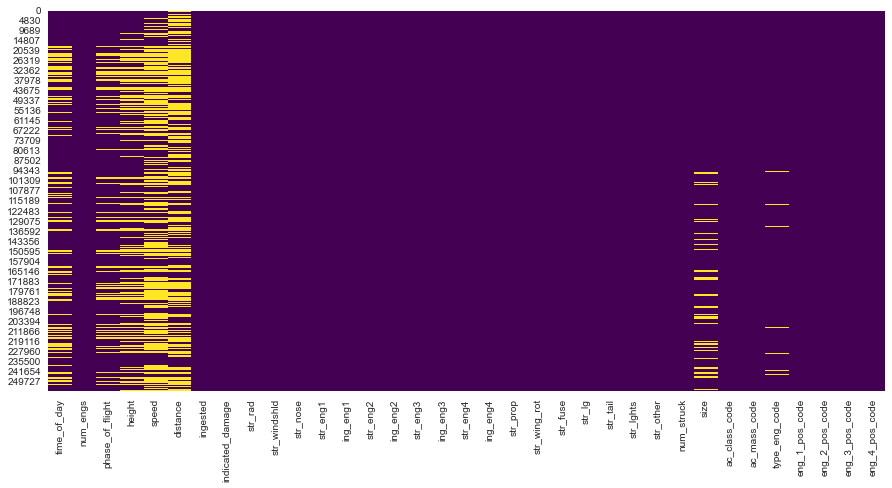

In [104]:
plt.figure(figsize=(15,7))
sns.heatmap(acraftvswild.isnull(), cbar = False, cmap = 'viridis')

#### We still have some null values in few of our columns. Except for the numerical categorical variables i.e. speed, distance and height, we will be removing the null values for all the rest of the columns

In [105]:
acraftvswild.dropna(axis=0, subset=['time_of_day'], inplace = True )

In [106]:
acraftvswild.dropna(axis=0, subset=['phase_of_flight'], inplace = True )

In [107]:
acraftvswild.dropna(axis=0, subset=['size'], inplace = True )

In [108]:
acraftvswild.dropna(axis=0, subset=['type_eng_code'], inplace = True )

### We still have several columns where we have string values as "NULL". For each of these we will remove these rows one by one

In [109]:
acraftvswild['num_struck'].value_counts()

1                97933
2-10             18205
11-100            1117
NULL               258
More than 100       44
Name: num_struck, dtype: int64

In [110]:
acraftvswild = acraftvswild[acraftvswild.num_struck != 'NULL']

In [111]:
acraftvswild['num_engs'].value_counts()

2       99681
1        8863
3        6963
4        1775
NULL       17
Name: num_engs, dtype: int64

In [112]:
acraftvswild = acraftvswild[acraftvswild.num_engs != 'NULL']

In [113]:
acraftvswild['ac_mass_code'].value_counts()

27001-272000 kg    76107
5701-27000 kg      22266
2251-5700 kg        9227
2250 kg or less     8628
above 272000 kg     1047
NULL                   7
Name: ac_mass_code, dtype: int64

In [114]:
acraftvswild = acraftvswild[acraftvswild.ac_mass_code != 'NULL']

In [115]:
acraftvswild['ac_class_code'].value_counts()

Airplane      114479
Helicopter      2792
NULL               3
Ultralight         1
Name: ac_class_code, dtype: int64

In [116]:
acraftvswild = acraftvswild[acraftvswild.ac_class_code != 'NULL']

### Imputing Numerical Data with Median Values

In [117]:
acraftvswild['height'] = acraftvswild['height'].fillna((acraftvswild['height'].median()))

In [118]:
acraftvswild['speed'] = acraftvswild['speed'].fillna((acraftvswild['speed'].median()))

In [119]:
acraftvswild['distance'] = acraftvswild['distance'].fillna((acraftvswild['distance'].median()))

## Feature Normalization

### Scaling Numerical Variables in order to tackle outliers if any 

In [120]:
from sklearn.preprocessing import StandardScaler

# Copying original dataframe
acraftvswildfinal = acraftvswild.copy()

scaler = StandardScaler()
num_cols = ['height', 'speed', 'distance']
acraftvswildfinal[num_cols] = scaler.fit_transform(acraftvswild[num_cols])

acraftvswildfinal.head(5)

,time_of_day,num_engs,phase_of_flight,height,speed,distance,ingested,indicated_damage,str_rad,str_windshld,...,str_other,num_struck,size,ac_class_code,ac_mass_code,type_eng_code,eng_1_pos_code,eng_2_pos_code,eng_3_pos_code,eng_4_pos_code
0,Night,1,Approach,-0.342889,-1.889544,-0.231728,False,False,False,False,...,False,1,Small,Airplane,2250 kg or less,Reciprocating Engine (Piston),At Nose Intake,NULL,NULL,NULL
1,Day,3,Landing Roll,-0.457489,-0.080473,-0.231728,False,False,False,False,...,False,1,Medium,Airplane,27001-272000 kg,Turbofan,On Aft Fuselage,In Empennage,On Aft Fuselage,NULL
3,Day,1,Approach,0.573907,0.270541,1.961445,False,True,False,True,...,False,1,Large,Airplane,2250 kg or less,Reciprocating Engine (Piston),At Nose Intake,NULL,NULL,NULL
4,Night,3,Approach,-0.342889,-0.134475,-0.231728,False,False,False,False,...,False,1,Small,Airplane,27001-272000 kg,Turbofan,On Aft Fuselage,In Empennage,On Aft Fuselage,NULL
5,Night,2,Approach,-0.285589,0.000530,-0.231728,False,False,False,False,...,False,1,Medium,Airplane,27001-272000 kg,Turbofan,On Aft Fuselage,On Aft Fuselage,NULL,NULL


#### Reordering the Features

In [121]:
acraftvswildfinal = acraftvswildfinal[['time_of_day', 'num_engs', 'phase_of_flight', 'height', 'speed',
       'distance', 'ingested', 'str_rad', 'str_windshld',
       'str_nose', 'str_eng1', 'ing_eng1', 'str_eng2', 'ing_eng2', 'str_eng3',
       'ing_eng3', 'str_eng4', 'ing_eng4', 'str_prop', 'str_wing_rot',
       'str_fuse', 'str_lg', 'str_tail', 'str_lghts', 'str_other',
       'num_struck', 'size', 'ac_class_code', 'ac_mass_code', 'type_eng_code',
       'eng_1_pos_code', 'eng_2_pos_code', 'eng_3_pos_code', 'eng_4_pos_code', 'indicated_damage']]

Text(0, 0.5, 'Number of Strikes')

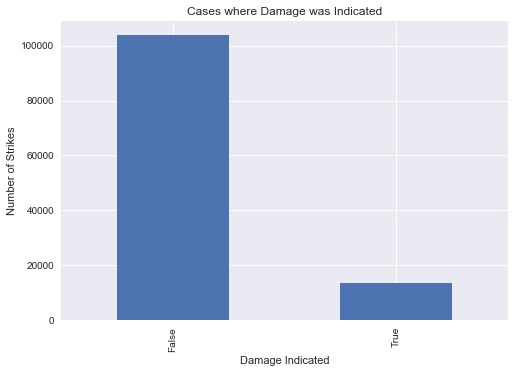

In [122]:
acraftvswildfinal['indicated_damage'].value_counts().plot(kind = 'bar')
plt.title('Cases where Damage was Indicated')
plt.xlabel('Damage Indicated')
plt.ylabel('Number of Strikes')

#### We see that our target variable is highly imbalanced and there is a big chance that even if we build the model it will be partial towards the majority data i.e. in our case incidents where the strike caused no damage. We can treat this by either replicating the minority data ourselves (manual oversampling) or we can use the SMOTE package which automatically does the oversampling by using K Nearest Neighbors to create data that is similar to the existing minority data but not the exact copy.
#### We will be using the SMOTE algorithm later on for our model

In [127]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
cat_cols = ['time_of_day', 'num_engs', 'phase_of_flight', 'ingested', 'str_rad', 'str_windshld',
       'str_nose', 'str_eng1', 'ing_eng1', 'str_eng2', 'ing_eng2', 'str_eng3',
       'ing_eng3', 'str_eng4', 'ing_eng4', 'str_prop', 'str_wing_rot',
       'str_fuse', 'str_lg', 'str_tail', 'str_lghts', 'str_other',
       'num_struck', 'size', 'ac_class_code', 'ac_mass_code', 'type_eng_code',
       'eng_1_pos_code', 'eng_2_pos_code', 'eng_3_pos_code', 'eng_4_pos_code']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(acraftvswildfinal[cat_cols]))
df_encoded.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
acraftvswildfinal = acraftvswildfinal.drop(cat_cols ,axis=1)
acraftvswildfinal = pd.concat([df_encoded, acraftvswildfinal], axis=1)

# Encode target value
acraftvswildfinal['indicated_damage'] = acraftvswildfinal['indicated_damage'].apply(lambda x: 1 if x == True else 0)

print('Shape of dataframe:', acraftvswildfinal.shape)
acraftvswildfinal.head()

Shape of dataframe: (170950, 106)


,time_of_day_Dawn,time_of_day_Day,time_of_day_Dusk,time_of_day_Night,num_engs_1,num_engs_2,num_engs_3,num_engs_4,phase_of_flight_Approach,phase_of_flight_Arrival,...,eng_3_pos_code_On Aft Fuselage,eng_4_pos_code_At Wing Root,eng_4_pos_code_Below The Wing,eng_4_pos_code_NULL,eng_4_pos_code_Nacelle-Mounted on Wing,eng_4_pos_code_On Aft Fuselage,height,speed,distance,indicated_damage
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.342889,-1.889544,-0.231728,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,-0.457489,-0.080473,-0.231728,0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.573907,0.270541,1.961445,1
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.342889,-0.134475,-0.231728,0


In [128]:
acraftvswildfinal = acraftvswildfinal.fillna(0)

## Using SMOTE to Balance Data

In [129]:
from imblearn.over_sampling import SMOTE

In [130]:
k = 10

df = acraftvswildfinal
# creating a new dataframe made of all the columns, except the target class
X = df.loc[:, df.columns != 'indicated_damage']
y = df.indicated_damage
sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [131]:
acraftvswild_bal = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
# rename the columns
acraftvswild_bal.columns = df.columns

In [132]:
acraftvswild_bal['indicated_damage'].value_counts()

0    157398
1    157398
Name: indicated_damage, dtype: int64

##### As we can see, the SMOTE algorithm has automatically balanced the data

In [133]:
acraftvswild_bal = acraftvswild_bal.fillna(0)

### Splitting the data into training and test datasets

In [134]:
feature = acraftvswild_bal.drop('indicated_damage', axis=1)

target = acraftvswild_bal['indicated_damage']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=42)

print('training features data:', X_train.shape)
print('testing features data:', X_test.shape)
print('training target data:', y_train.shape)
print('testing target data:', y_test.shape)

training features data: (251836, 105)
testing features data: (62960, 105)
training target data: (251836,)
testing target data: (62960,)


In [135]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Test Data Prediction
    y_pred = model.predict(x_test)

    # Calculating Different Metric Scores
    acc = metrics.accuracy_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    # ROC Curve
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

# Modelling

## 1. Decision Tree

In [136]:
from sklearn import tree

# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Model Evaluation

In [137]:
# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Recall:', dtc_eval['rec'])
print('Precision:', dtc_eval['prec'])
print('F1 Score:', dtc_eval['f1'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.8547966963151207
Recall: 0.8076091105738643
Precision: 0.891369988062636
F1 Score: 0.8474248139123468
Area Under Curve: 0.9029372843436047
Confusion Matrix:
 [[28430  3094]
 [ 6048 25388]]


## 2. Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Model Evaluation

In [139]:
# Evaluate Model
rf_eval = evaluate_model(rf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Recall:', rf_eval['rec'])
print('Precision:', rf_eval['prec'])
print('F1 Score:', rf_eval['f1'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.8675508259212198
Recall: 0.8225919328158798
Precision: 0.9034974319555571
F1 Score: 0.8611485755199226
Area Under Curve: 0.9461444633930675
Confusion Matrix:
 [[28762  2762]
 [ 5577 25859]]


## 3. Naive Bayes Model

In [140]:
from sklearn.naive_bayes import GaussianNB

# Building Naive Bayes model 
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

### Model Evaluation

In [141]:
# Evaluate Model
nb_eval = evaluate_model(nb, X_test, y_test)

# Print result
print('Accuracy:', nb_eval['acc'])
print('Recall:', nb_eval['rec'])
print('Precision:', nb_eval['prec'])
print('F1 Score:', nb_eval['f1'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.5100063532401525
Recall: 0.9702570301565084
Precision: 0.5048497086864406
F1 Score: 0.664133606236119
Area Under Curve: 0.586657812496998
Confusion Matrix:
 [[ 1609 29915]
 [  935 30501]]


### Comparing the Models

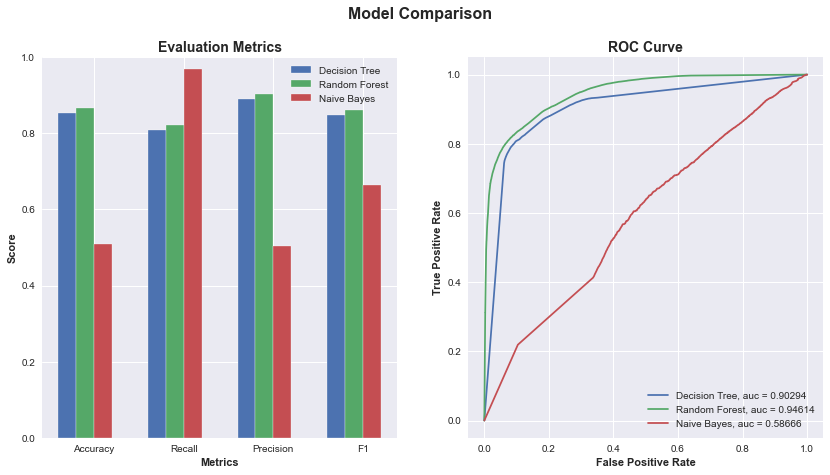

In [142]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['rec'], dtc_eval['prec'], dtc_eval['f1']]
rf_score = [rf_eval['acc'], rf_eval['rec'], rf_eval['prec'], rf_eval['f1']]
nb_score = [nb_eval['acc'], nb_eval['rec'], nb_eval['prec'], nb_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Recall', 'Precision', 'F1']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

### Metric Selection

#### We choose to use the recall metric as it measures how well the model is predicting the occurance of damage, which is our target variable. In other words, it gives us the true positive rate or percentage of positives we have correctly predicted. Since we are predicting the "Class" variable here our aim is to predicted the true positives correctly. Hence, we choose recall as our Metric of choice

In [143]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50],
    'max_features': [4],
    'min_samples_leaf': [3],
    'min_samples_split': [12],
    'n_estimators': [250]
}

# Create a base model
rf_grids = RandomForestClassifier(random_state=42)

# Initiate the grid search model
grid_search = GridSearchCV(estimator=rf_grids, param_grid=param_grid, scoring='recall',
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 250}

In [144]:
# Select best model with best fit
best_grid = grid_search.best_estimator_

# Evaluate Model
best_grid_eval = evaluate_model(best_grid, X_test, y_test)

# Print result
print('Accuracy:', best_grid_eval['acc'])
print('Recall:', best_grid_eval['rec'])
print('Precision:', best_grid_eval['prec'])
print('F1 Score:', best_grid_eval['f1'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])

Accuracy: 0.841168996188056
Recall: 0.8463544980277389
Precision: 0.8372985901309165
F1 Score: 0.8418021894576979
Area Under Curve: 0.930118267754124
Confusion Matrix:
 [[26354  5170]
 [ 4830 26606]]


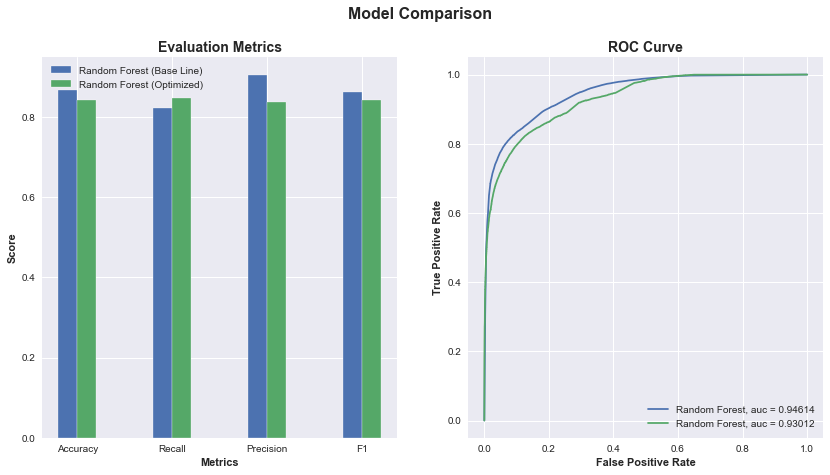

Change of -3.04% on accuracy.
Change of 2.89% on recall.
Change of -7.33% on precision.
Change of -2.25% on F1 score.
Change of -1.69% on AUC.


In [145]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
rf_score = [rf_eval['acc'], rf_eval['rec'], rf_eval['prec'], rf_eval['f1']]
best_grid_score = [best_grid_eval['acc'], best_grid_eval['rec'], best_grid_eval['prec'], best_grid_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(rf_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest (Base Line)')
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='Random Forest (Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Recall', 'Precision', 'F1']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
# ax1.set_ylim(0, 1)

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(best_grid_eval['fpr'], best_grid_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(best_grid_eval['auc']))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * ((best_grid_eval['acc'] - rf_eval['acc']) / rf_eval['acc'])))
print('Change of {:0.2f}% on recall.'.format(100 * ((best_grid_eval['rec'] - rf_eval['rec']) / rf_eval['rec'])))
print('Change of {:0.2f}% on precision.'.format(100 * ((best_grid_eval['prec'] - rf_eval['prec']) / rf_eval['prec'])))
print('Change of {:0.2f}% on F1 score.'.format(100 * ((best_grid_eval['f1'] - rf_eval['f1']) / rf_eval['f1'])))
print('Change of {:0.2f}% on AUC.'.format(100 * ((best_grid_eval['auc'] - rf_eval['auc']) / rf_eval['auc'])))

## Making Predictions

In [146]:
acraftvswild_bal['damage_prediction'] = best_grid.predict(feature)
acraftvswild_bal['damage_prediction'] = acraftvswild_bal['damage_prediction'].apply(lambda x: 'yes' if x == 0 else 'no')

acraftvswild_bal.head(50)

,time_of_day_Dawn,time_of_day_Day,time_of_day_Dusk,time_of_day_Night,num_engs_1,num_engs_2,num_engs_3,num_engs_4,phase_of_flight_Approach,phase_of_flight_Arrival,...,eng_4_pos_code_At Wing Root,eng_4_pos_code_Below The Wing,eng_4_pos_code_NULL,eng_4_pos_code_Nacelle-Mounted on Wing,eng_4_pos_code_On Aft Fuselage,height,speed,distance,indicated_damage,damage_prediction
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.342889,-1.889544,-0.231728,0,no
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.457489,-0.080473,-0.231728,0,no
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0,yes
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.573907,0.270541,1.961445,1,yes
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.342889,-0.134475,-0.231728,0,no
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.285589,0.000530,-0.231728,0,yes
6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,5.558988,3.780679,-0.231728,0,no
7,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0,yes
8,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.457489,-0.539491,-0.231728,0,yes
9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.402008,0.810562,-0.231728,0,no


### Summary

- We conducted EDA on the FAA Wildlife Strikes Dataset and were able to identify categorical variables to build our prediction model
- We imputed numerical columns using median values
- We used SMOTE algorithm to handle imbalance in our target variable
- We used Standard Scaler to Scale our numerical columns to tackle any outliers
- We used OneHotEncoder to convert categorical variables to boolean strings to be fed to the model
- We ran three different types of models i.e Decision Tree, Random Forest Classifier and Naive Bayes
- We compared the performance of each of these models and found the performance of Random Forest Classifier optimum
- We tried to improve the model performance using grid search
- We were able to successfully build a binary classification random forest model predicting whether an aircraft-wildlife collision will cause damage to the aircraft or not with a 85.15% recall score

### References:

- https://www.kaggle.com/alexisbcook/cross-validation
- https://www.simplilearn.com/tutorials/machine-learning-tutorial/random-forest-algorithm
- https://www.python-graph-gallery.com/11-grouped-barplot
- https://scikit-learn.org/stable/index.html
- https://www.kite.com/blog/python/smote-python-imbalanced-learn-for-oversampling/